# Ablation Study - over ß-Values 

In [1]:
import os
import sys
from tqdm import tqdm  

from datetime import datetime

import torch
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# import pandas
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import rcParams

import gc
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

from jutils import denorm
from jutils import ims_to_grid
from jutils.vision import tensor2im
from jutils import tensor2im, ims_to_grid

while not os.path.exists('ldm'):
    %cd ..
assert os.path.exists('ldm')

from data_processing.tools.norm import denorm_tensor
from ldm.trainer_bvae_ti2 import TrainerModuleLatentBetaVae
from ldm.dataloader.dataloader.hdf5_dataloader import HDF5DataModule

DEV = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
gc.collect()

print(f"Memory Allocated: {torch.cuda.memory_allocated(DEV) / 1024 ** 3:.2f} GB")
print(f"Memory Cached: {torch.cuda.memory_reserved(DEV) / 1024 ** 3:.2f} GB")

/export/home/ra93jiz/dev/Img-IDM/ldm/evaluation
/export/home/ra93jiz/dev/Img-IDM/ldm
/export/home/ra93jiz/dev/Img-IDM
Memory Allocated: 0.00 GB
Memory Cached: 0.00 GB


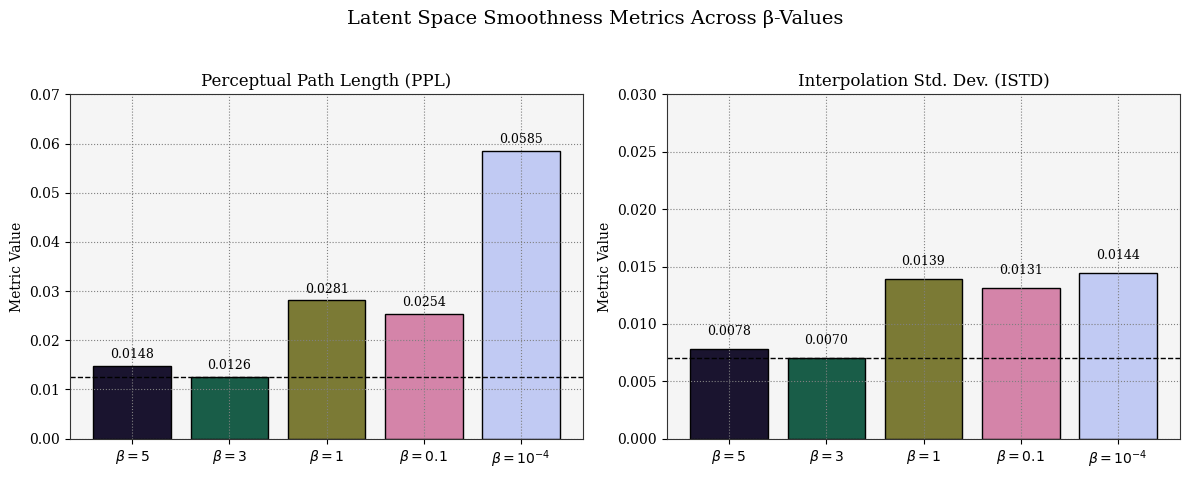

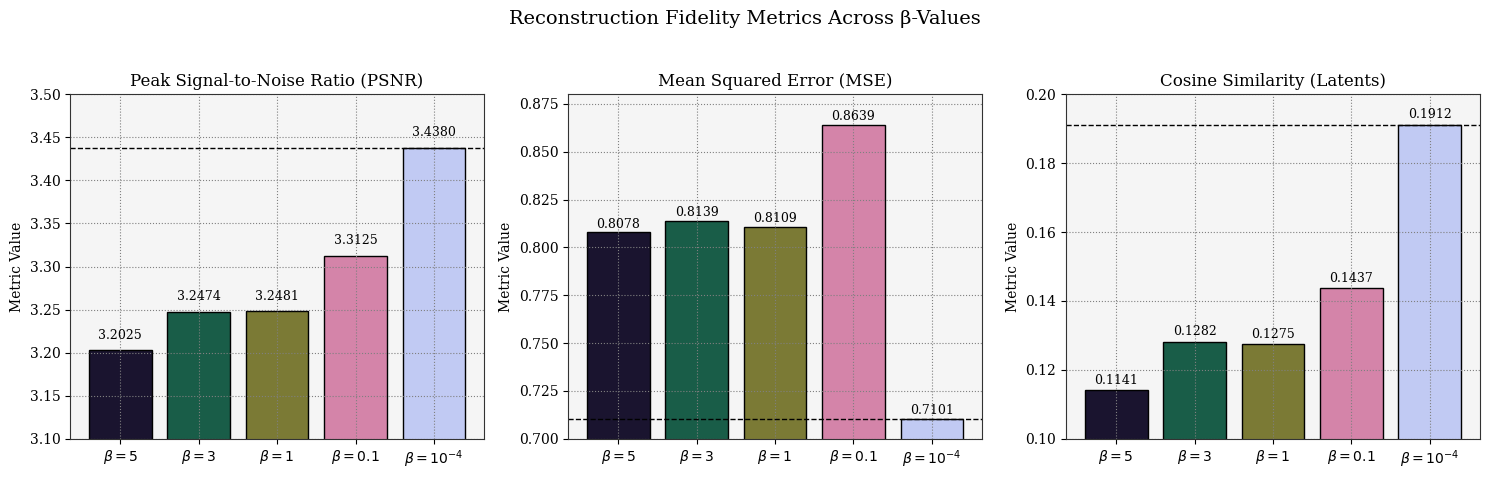

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the Cambria-like font (fallback if Cambria Math is unavailable)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Cambria", "Times New Roman", "DejaVu Serif"]
plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["axes.edgecolor"] = "#333333"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.color"] = "grey"
plt.rcParams["axes.grid"] = True

# Data
beta_values = [5, 3, 1, 0.1, 0.0001]
labels = [r"$\beta=5$", r"$\beta=3$", r"$\beta=1$", r"$\beta=0.1$", r"$\beta=10^{-4}$"]
colors = plt.cm.cubehelix(np.linspace(0.1, 0.8, len(beta_values)))

# Smoothness Metrics (CDPL and ISTD)
cdpl = [0.0148, 0.0126, 0.0281, 0.0254, 0.0585]
istd = [0.0078, 0.0070, 0.0139, 0.0131, 0.0144]

# Reconstruction Metrics
psnr = [3.2025, 3.2474, 3.2481, 3.3125, 3.4380]
mse  = [0.8078, 0.8139, 0.8109, 0.8639, 0.7101]
cos  = [0.1141, 0.1282, 0.1275, 0.1437, 0.1912]


# Plot Smoothness Metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
metrics = [cdpl, istd]
titles = ["Cosine Distance Path Length (CDPL)", "Interpolation Std. Dev. (ISTD)"]
y_lims = [(0, 0.07), (0, 0.03)]

for i, ax in enumerate(axs):
    bars = ax.bar(labels, metrics[i], color=colors, edgecolor='black')
    best_idx = np.argmin(metrics[i])
    ax.axhline(y=metrics[i][best_idx], color="black", linestyle="--", linewidth=1)
    for bar, val in zip(bars, metrics[i]):
        ax.text(bar.get_x() + bar.get_width()/2., val + 0.001, f"{val:.4f}", ha='center', va='bottom', fontsize=9)
    ax.set_ylim(y_lims[i])
    ax.set_title(titles[i], fontsize=12)
    ax.set_ylabel("Metric Value")

fig.suptitle("Latent Space Smoothness Metrics Across β-Values", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot Reconstruction Metrics
fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))
recon_metrics = [psnr, mse, cos]
recon_titles = ["Peak Signal-to-Noise Ratio (PSNR)", "Mean Squared Error (MSE)", "Cosine Similarity (Latents)"]
recon_y_lims = [(3.1, 3.5), (0.5, 0.88), (0.1, 0.2)]


for i, ax in enumerate(axs2):
    bars = ax.bar(labels, recon_metrics[i], color=colors, edgecolor='black')
    if i in [0, 2]:  # PSNR and CosSim: higher is better
        best_idx = np.argmax(recon_metrics[i])
    else:            # MSE: lower is better
        best_idx = np.argmin(recon_metrics[i])
    ax.axhline(y=recon_metrics[i][best_idx], color="black", linestyle="--", linewidth=1)
    for bar, val in zip(bars, recon_metrics[i]):
        offset = 0.001 if i != 0 else 0.01
        ax.text(bar.get_x() + bar.get_width()/2., val + offset, f"{val:.4f}", ha='center', va='bottom', fontsize=9)
    ax.set_ylim(recon_y_lims[i])
    ax.set_title(recon_titles[i], fontsize=12)
    ax.set_ylabel("Metric Value")

fig2.suptitle("Reconstruction Fidelity Metrics Across β-Values", fontsize=14)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


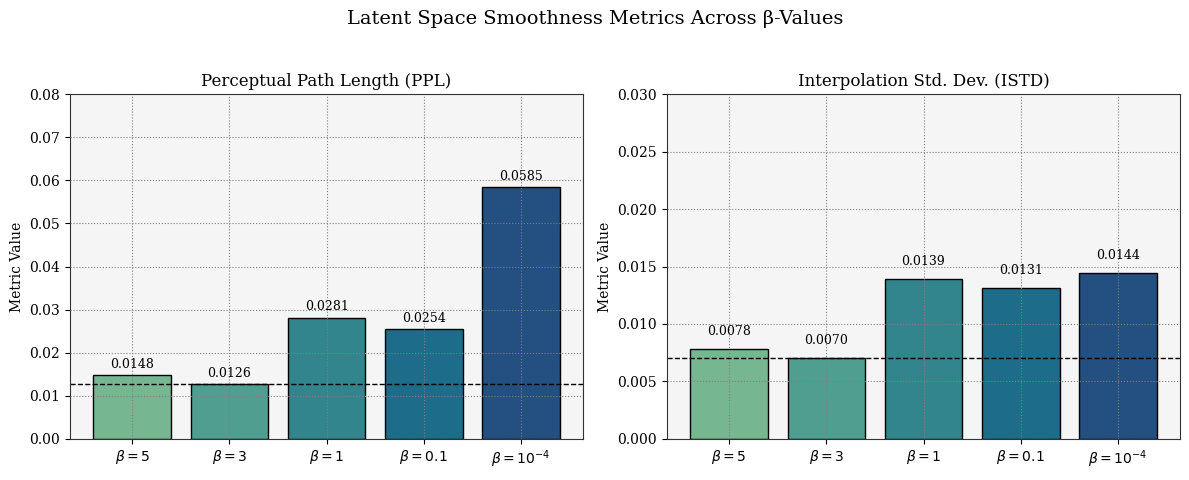

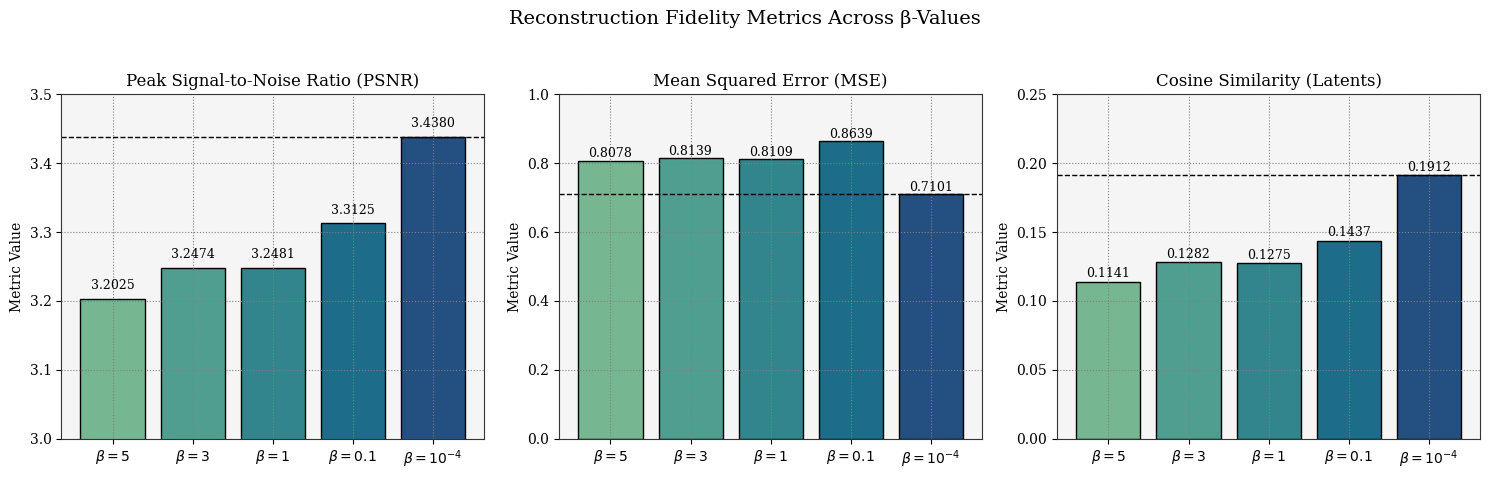

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Set font and style
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Cambria", "Times New Roman", "DejaVu Serif"]
plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["axes.edgecolor"] = "#333333"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.color"] = "grey"
plt.rcParams["axes.grid"] = True

# Data
beta_values = [5, 3, 1, 0.1, 0.0001]
labels = [r"$\beta=5$", r"$\beta=3$", r"$\beta=1$", r"$\beta=0.1$", r"$\beta=10^{-4}$"]

# Use a blue shaded palette
colors = cm.Blues(np.linspace(0.5, 0.9, len(beta_values)))
colors = sns.cubehelix_palette(10, rot=-.25, light=.7)  # Alternative color palette

# "crest"
colors = sns.color_palette("crest", n_colors=len(beta_values))

# Smoothness Metrics (CDPL and ISTD)
cdpl = [0.0148, 0.0126, 0.0281, 0.0254, 0.0585]
istd = [0.0078, 0.0070, 0.0139, 0.0131, 0.0144]

# Reconstruction Metrics
psnr = [3.2025, 3.2474, 3.2481, 3.3125, 3.4380]
mse  = [0.8078, 0.8139, 0.8109, 0.8639, 0.7101]
cos  = [0.1141, 0.1282, 0.1275, 0.1437, 0.1912]


# Plot Smoothness Metrics
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
metrics = [cdpl, istd]
titles = ["Cosine Distance Path Length (CDPL)", "Interpolation Std. Dev. (ISTD)"]
y_lims = [(0, 0.08), (0, 0.03)]

for i, ax in enumerate(axs):
    bars = ax.bar(labels, metrics[i], color=colors, edgecolor='black')
    best_idx = np.argmin(metrics[i])
    ax.axhline(y=metrics[i][best_idx], color="black", linestyle="--", linewidth=1)
    for bar, val in zip(bars, metrics[i]):
        ax.text(bar.get_x() + bar.get_width()/2., val + 0.001, f"{val:.4f}", ha='center', va='bottom', fontsize=9)
    ax.set_ylim(y_lims[i])
    ax.set_title(titles[i], fontsize=12)
    ax.set_ylabel("Metric Value")

fig.suptitle("Latent Space Smoothness Metrics Across β-Values", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot Reconstruction Metrics
fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))
recon_metrics = [psnr, mse, cos]
recon_titles = ["Peak Signal-to-Noise Ratio (PSNR)", "Mean Squared Error (MSE)", "Cosine Similarity (Latents)"]
recon_y_lims = [(3.0, 3.5), (0.0, 1.0), (0.0, 0.25)]


for i, ax in enumerate(axs2):
    bars = ax.bar(labels, recon_metrics[i], color=colors, edgecolor='black')
    best_idx = np.argmax(recon_metrics[i]) if i in [0, 2] else np.argmin(recon_metrics[i])
    ax.axhline(y=recon_metrics[i][best_idx], color="black", linestyle="--", linewidth=1)
    for bar, val in zip(bars, recon_metrics[i]):
        offset = 0.001 if i != 0 else 0.01
        ax.text(bar.get_x() + bar.get_width()/2., val + offset, f"{val:.4f}", ha='center', va='bottom', fontsize=9)
    ax.set_ylim(recon_y_lims[i])
    ax.set_title(recon_titles[i], fontsize=12)
    ax.set_ylabel("Metric Value")

fig2.suptitle("Reconstruction Fidelity Metrics Across β-Values", fontsize=14)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
